Baseline DataFrame shape: (76, 7)
Advanced DataFrame shape: (76, 6)

=== Merged Data (head) ===
   Coin     Horizon  Naive_RMSE  Naive_MAE ARIMA_Order  ARIMA_RMSE  ARIMA_MAE  \
0   ADA   Close_t+1    0.024669   0.014846   (1, 1, 1)    0.249718   0.166307   
1   ADA  Close_t+30    0.187761   0.112849   (1, 1, 1)    0.294923   0.201555   
2   ADA   Close_t+7    0.071919   0.044098   (1, 1, 1)    0.256589   0.172460   
3   ADA  Close_t+90    0.307139   0.226240   (1, 1, 1)    0.334300   0.246318   
4  AVAX   Close_t+1    1.901590   1.342636   (2, 1, 2)   10.238011   8.759491   

    RF_RMSE    RF_MAE  XGB_RMSE   XGB_MAE  
0  0.025445  0.016708  0.028275  0.018721  
1  0.199159  0.127662  0.203981  0.125602  
2  0.070317  0.048611  0.076173  0.052353  
3  0.324284  0.217756  0.316206  0.209011  
4  2.337897  1.626471  2.633515  1.840575  

=== Melted Data (head) ===
   Coin     Horizon  Model      RMSE
0   ADA   Close_t+1  Naive  0.024669
1   ADA  Close_t+30  Naive  0.187761
2   ADA   Clos

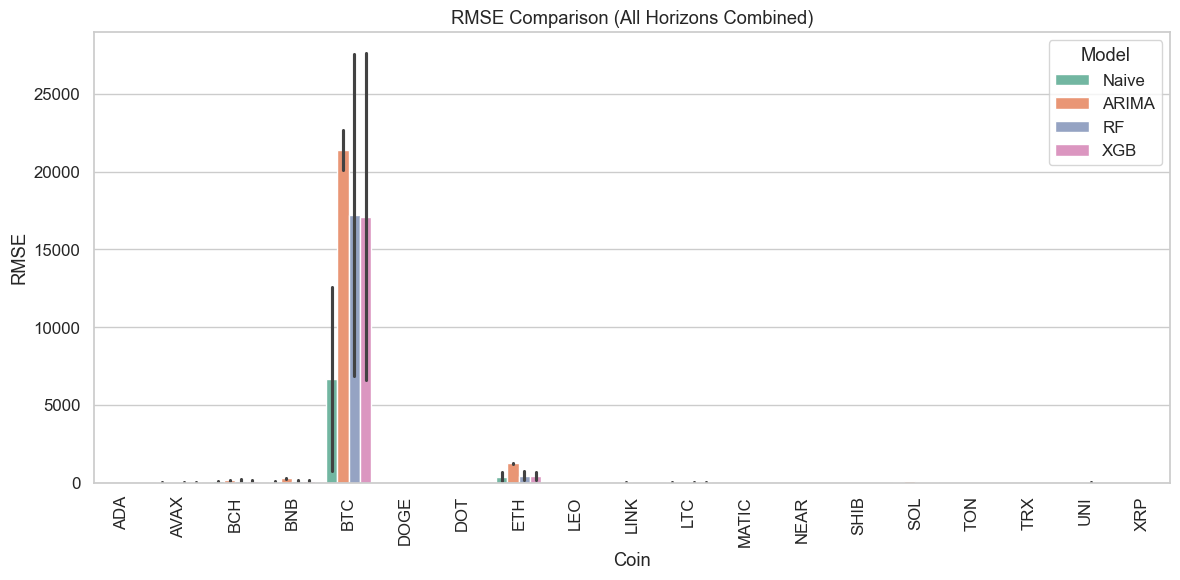

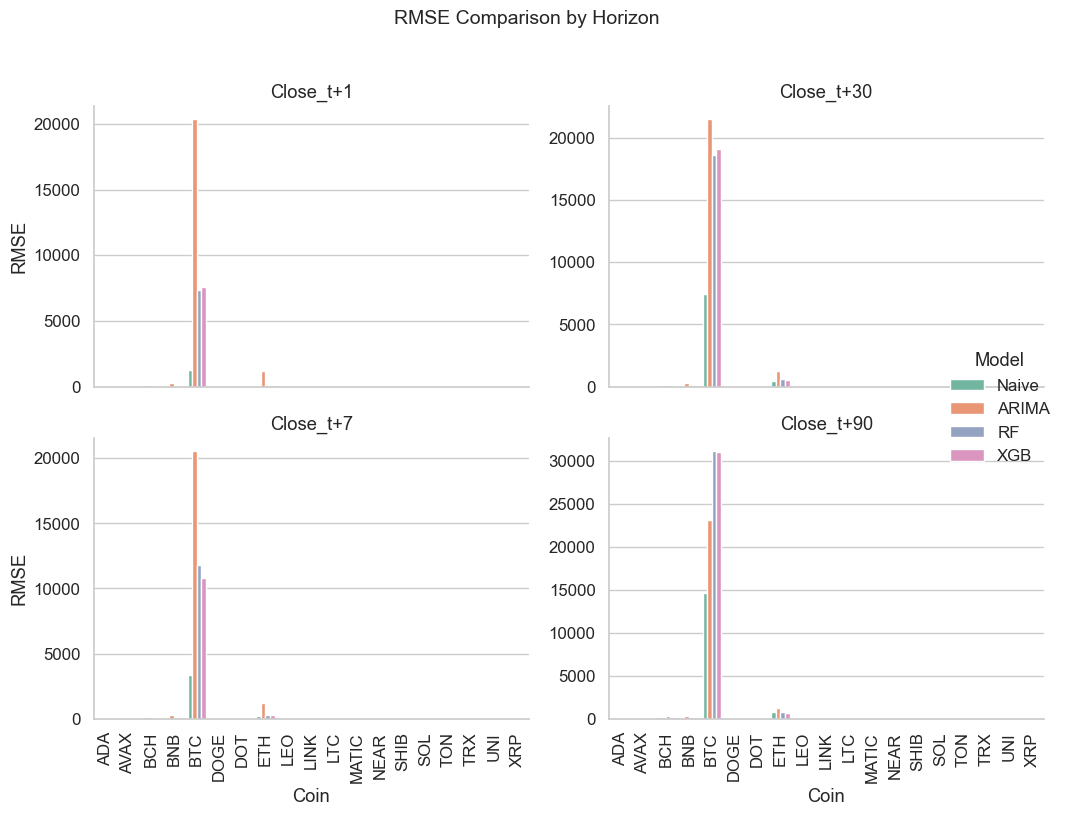


=== Mean RMSE by Horizon & Model ===
       Horizon  Model     Avg_RMSE
0    Close_t+1  ARIMA  1162.708449
1    Close_t+1  Naive    74.197075
2    Close_t+1     RF   398.269275
3    Close_t+1    XGB   407.512532
4   Close_t+30  ARIMA  1227.306549
5   Close_t+30  Naive   425.862015
6   Close_t+30     RF  1027.458782
7   Close_t+30    XGB  1047.751039
8    Close_t+7  ARIMA  1173.626673
9    Close_t+7  Naive   194.082416
10   Close_t+7     RF   646.399677
11   Close_t+7    XGB   591.415969
12  Close_t+90  ARIMA  1318.815754
13  Close_t+90  Naive   833.583198
14  Close_t+90     RF  1712.905132
15  Close_t+90    XGB  1704.449636

=== Pivoted Summary Table ===
Model             ARIMA       Naive           RF          XGB
Horizon                                                      
Close_t+1   1162.708449   74.197075   398.269275   407.512532
Close_t+30  1227.306549  425.862015  1027.458782  1047.751039
Close_t+7   1173.626673  194.082416   646.399677   591.415969
Close_t+90  1318.815754  8

In [1]:
# 06_final_comparison.ipynb

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)

DATA_FOLDER = "../data"

# ------------------------------------------------------------------------------
# 1) Load Baseline & Advanced CSV
# ------------------------------------------------------------------------------
baseline_csv = os.path.join(DATA_FOLDER, "baseline_results_multihorizon_no_pmdarima.csv")
advanced_csv = os.path.join(DATA_FOLDER, "advanced_ratio_multihorizon_results_optimized.csv")

if not os.path.exists(baseline_csv):
    raise FileNotFoundError(f"Baseline CSV not found: {baseline_csv}")
if not os.path.exists(advanced_csv):
    raise FileNotFoundError(f"Advanced CSV not found: {advanced_csv}")

baseline_df = pd.read_csv(baseline_csv)
advanced_df = pd.read_csv(advanced_csv)

print("Baseline DataFrame shape:", baseline_df.shape)
print("Advanced DataFrame shape:", advanced_df.shape)

# ------------------------------------------------------------------------------
# 2) Merge on ['Coin','Horizon']
#    This ensures we can align per coin & forecast horizon.
# ------------------------------------------------------------------------------
merged_df = pd.merge(baseline_df, advanced_df,
                     on=["Coin", "Horizon"],
                     how="outer",
                     suffixes=("_baseline", "_adv"))  # Just for clarity if needed

print("\n=== Merged Data (head) ===")
print(merged_df.head())

# ------------------------------------------------------------------------------
# 3) Create a "long" or "melted" DataFrame for each model's RMSE
#    We'll compare: Naive, ARIMA, RF, XGB
# ------------------------------------------------------------------------------
rmse_cols = ["Naive_RMSE", "ARIMA_RMSE", "RF_RMSE", "XGB_RMSE"]

# Filter out rows that are entirely NaN in those columns (just in case)
merged_df_filtered = merged_df.dropna(subset=rmse_cols, how="all")

long_df = merged_df_filtered.melt(
    id_vars=["Coin", "Horizon"], 
    value_vars=rmse_cols, 
    var_name="Model", 
    value_name="RMSE"
)
# Model will be e.g. "Naive_RMSE" => you can rename them if you want
long_df["Model"] = long_df["Model"].str.replace("_RMSE", "")  # So it becomes "Naive","ARIMA","RF","XGB"

print("\n=== Melted Data (head) ===")
print(long_df.head())

# ------------------------------------------------------------------------------
# 4) Example Plot #1: Single bar chart per horizon, grouping by Coin, color by Model
#    You can do multiple horizons side-by-side or FacetGrid.
# ------------------------------------------------------------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=long_df,
    x="Coin", y="RMSE",
    hue="Model",
    errorbar="sd",  # or None to remove error bars
    palette="Set2"
)
plt.title("RMSE Comparison (All Horizons Combined)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title="Model")
plt.show()

# ------------------------------------------------------------------------------
# 5) Example Plot #2: Facet by Horizon (so each horizon gets its own subplot)
# ------------------------------------------------------------------------------
g = sns.catplot(
    data=long_df,
    x="Coin", y="RMSE", hue="Model",
    col="Horizon",
    kind="bar",
    col_wrap=2,       # Adjust for how many subplots per row
    height=4, aspect=1.2,
    palette="Set2",
    sharey=False      # each horizon can have its own scale
)

g.set_titles("{col_name}")  # Show the horizon in each subplot title
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel("Coin")
g.set_ylabels("RMSE")
g.fig.suptitle("RMSE Comparison by Horizon", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 6) Additional Analysis
#    - You can rank or highlight the best model per coin/horizon
#    - Summaries like average RMSE across coins, etc.
# ------------------------------------------------------------------------------
summary = (long_df
           .groupby(["Horizon", "Model"], as_index=False)
           .agg({"RMSE":"mean"})
           .rename(columns={"RMSE":"Avg_RMSE"}))

print("\n=== Mean RMSE by Horizon & Model ===")
print(summary)

# Example: pivot the summary for a quick table
pivot_summary = summary.pivot(index="Horizon", columns="Model", values="Avg_RMSE")
print("\n=== Pivoted Summary Table ===")
print(pivot_summary)

# ------------------------------------------------------------------------------
# 7) Save your merged or summary CSV if desired
# ------------------------------------------------------------------------------
output_csv = os.path.join(DATA_FOLDER, "final_comparison_merged.csv")
merged_df.to_csv(output_csv, index=False)
print(f"\nSaved final merged comparison to: {output_csv}")
